In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer

In [81]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/submission.csv', index_col='Id')

In [3]:
train.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1820,1,80.15,80.15,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Credit card (automatic),1
4350,26,90.10,2312.55,Female,0,Yes,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),0
3032,19,20.20,382.2,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
635,59,101.10,6039.9,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,No,Electronic check,1
1418,10,85.25,855.3,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [5]:
num_cols = train.columns[:3].to_list()
num_cols

['ClientPeriod', 'MonthlySpending', 'TotalSpent']

In [6]:
cat_cols = train.columns[3:-1].to_list()
cat_cols

['Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod']

In [7]:
feature_cols = num_cols + cat_cols
feature_cols

['ClientPeriod',
 'MonthlySpending',
 'TotalSpent',
 'Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod']

In [8]:
target_col = train.columns[-1]
target_col

'Churn'

In [9]:
train = train.drop_duplicates()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5268 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   object 
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlineTV  

In [10]:
train['TotalSpent'] = pd.to_numeric(train['TotalSpent'], errors='coerce')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5268 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5259 non-null   float64
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlineTV  

In [75]:
test['TotalSpent'] = pd.to_numeric(test['TotalSpent'], errors='coerce')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1759 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [11]:
train.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [12]:
train[train['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [13]:
train['TotalSpent'] = train['TotalSpent'].fillna(0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5268 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   float64
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlineTV  

In [76]:
test['TotalSpent'] = test['TotalSpent'].fillna(0)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

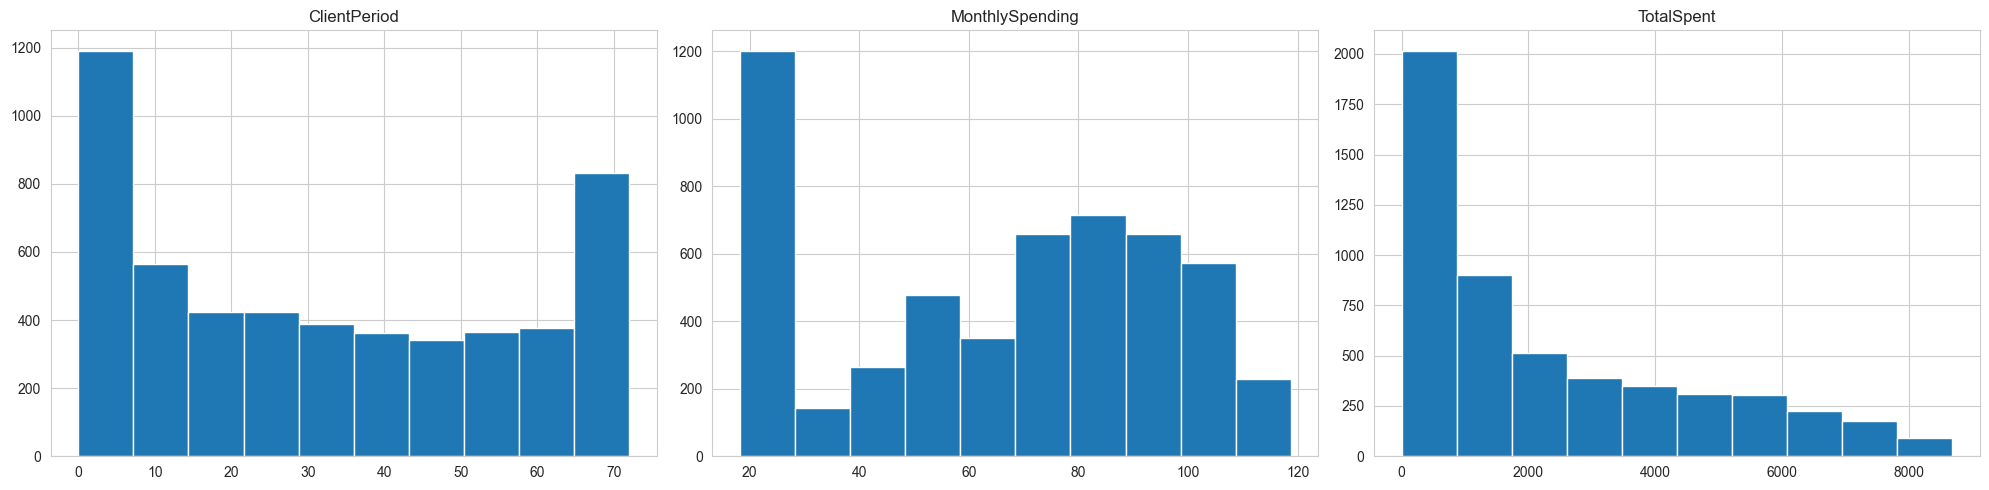

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, col in enumerate(num_cols):
    axs[i].hist(train[col])
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

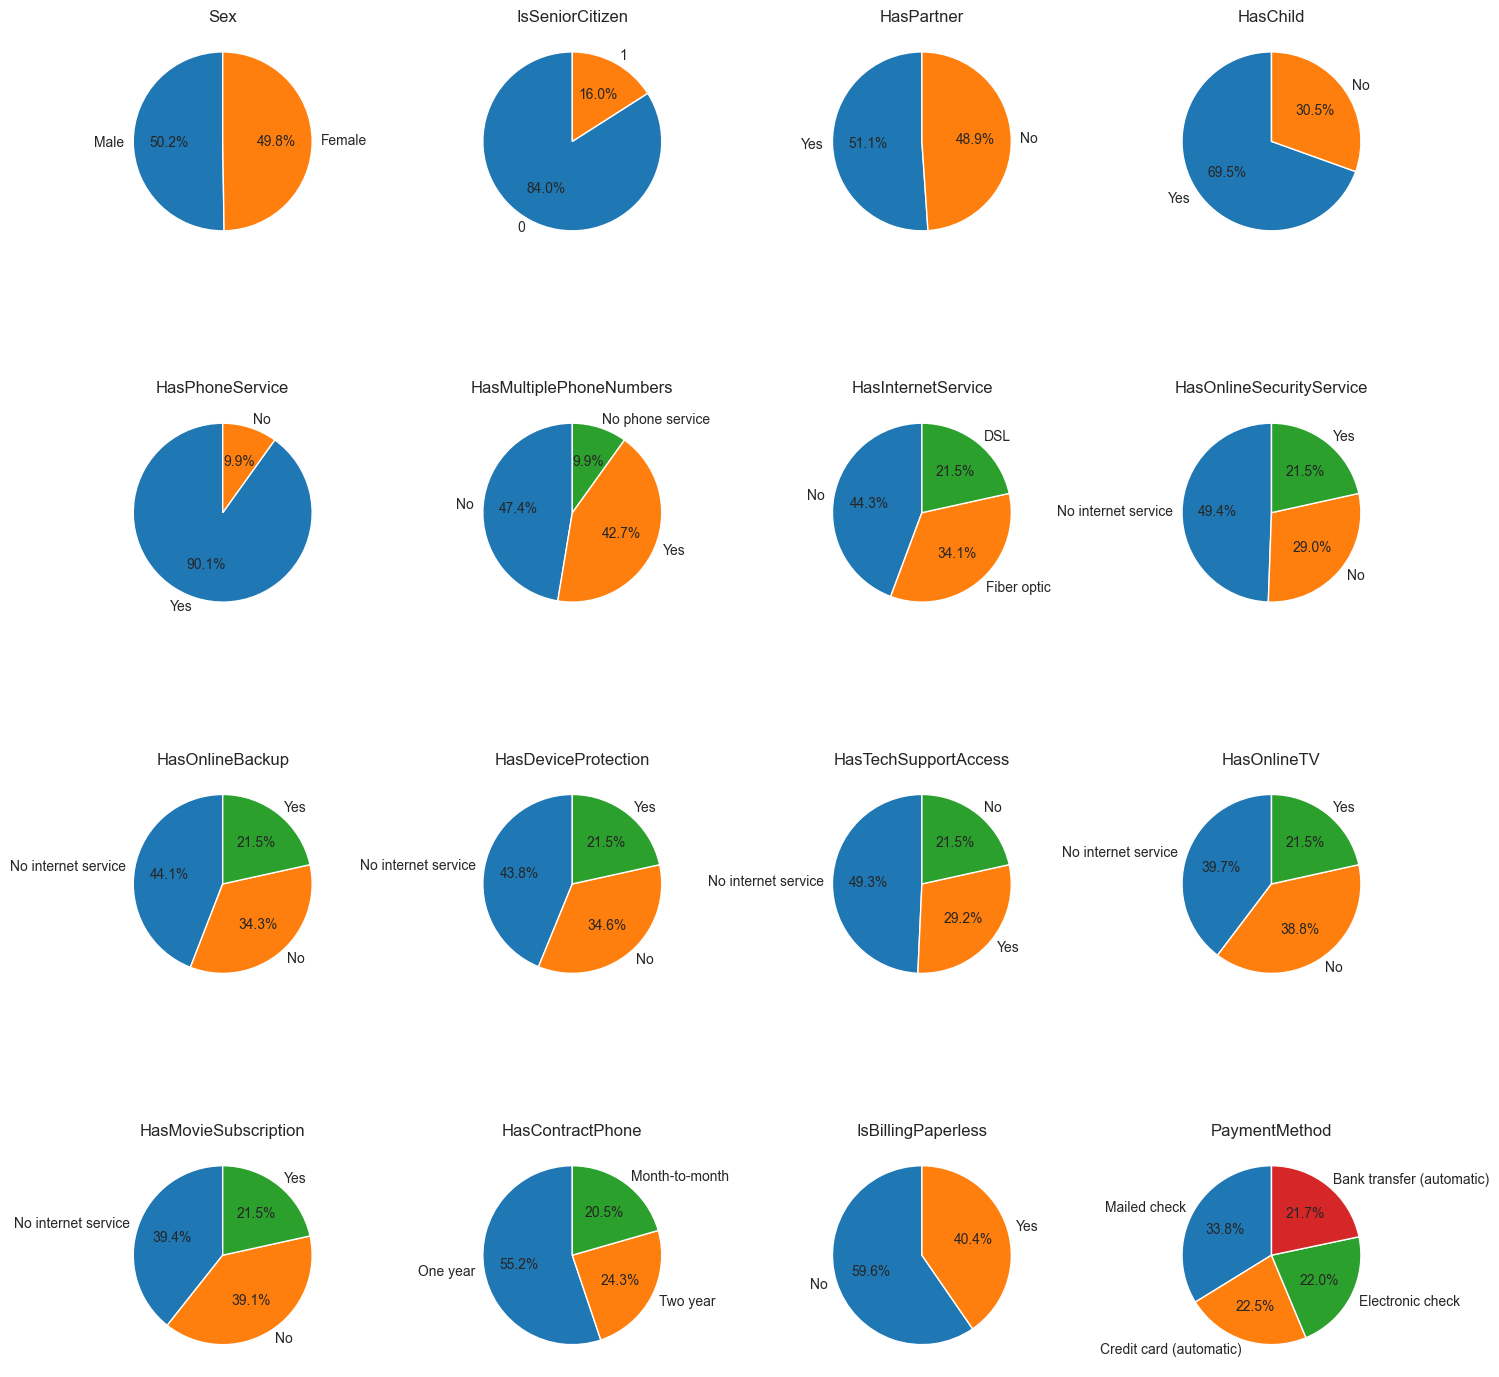

In [15]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, col in enumerate(cat_cols):
    axs[i // 4, i % 4].pie(train[col].value_counts(), labels=train[col].unique(), autopct='%1.1f%%', startangle=90)
    axs[i // 4, i % 4].set_title(col)
plt.tight_layout()
plt.show()

In [16]:
le = LabelEncoder()
num_train = train[num_cols]
cat_train = train[cat_cols]
cat_train_encoded = cat_train.apply(le.fit_transform)
train_encoded = pd.concat([num_train, cat_train_encoded], axis=1)

In [17]:
train_encoded = pd.concat([train_encoded, train[target_col]], axis=1)
train_encoded.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,1,0,1,1,1,0,2,1,1,1,1,1,1,1,0,3,0
1,72,25.85,1872.20,1,0,1,0,1,2,2,1,1,1,1,1,1,2,0,1,0
2,1,75.90,75.90,1,0,0,0,1,0,1,0,0,0,2,0,0,0,1,2,1
3,32,79.30,2570.00,0,1,1,0,1,2,1,0,0,2,0,0,0,0,0,3,0
4,60,115.25,6758.45,0,0,1,1,1,2,1,2,2,2,2,2,2,2,0,1,0


In [79]:
test_encoded = pd.concat([test[num_cols], test[cat_cols].apply(le.fit_transform)], axis=1)
test_encoded.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,1,0,1,0,1,2,0,2,0,0,0,0,0,1,0,1
1,29,98.50,3004.15,1,1,1,0,1,2,1,0,0,2,0,2,2,0,1,2
2,9,76.25,684.85,1,0,0,0,1,2,1,0,0,0,0,0,0,0,1,2
3,67,74.00,4868.40,0,0,1,1,1,2,0,2,2,0,2,2,0,2,0,1
4,71,20.10,1389.60,0,0,1,1,1,0,2,1,1,1,1,1,1,2,0,0


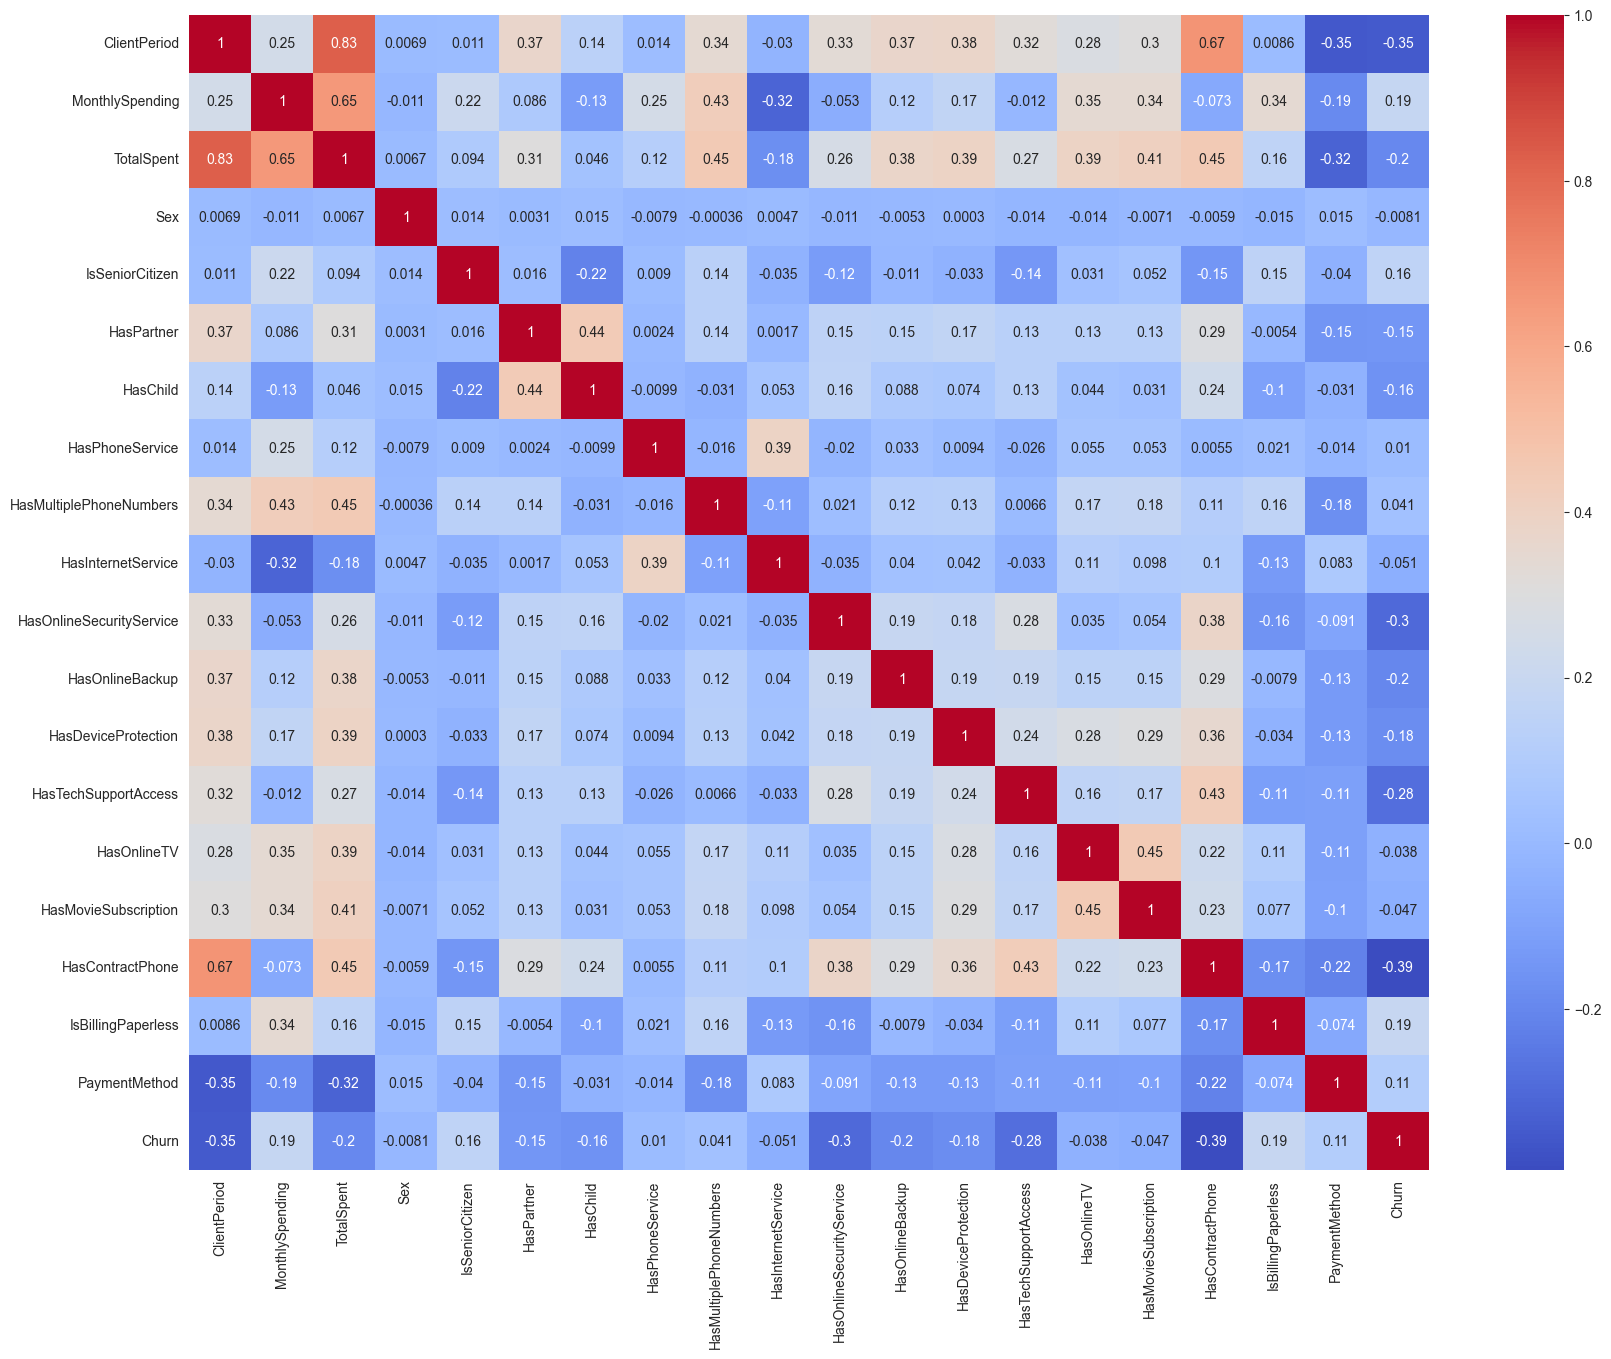

In [18]:
corr_matrix = train_encoded.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=plt.subplots(figsize=(20, 15))[1])
plt.show()

In [44]:
X = train_encoded[feature_cols]
X.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,55,19.50,1026.35,1,0,1,1,1,0,2,1,1,1,1,1,1,1,0,3
1,72,25.85,1872.20,1,0,1,0,1,2,2,1,1,1,1,1,1,2,0,1
2,1,75.90,75.90,1,0,0,0,1,0,1,0,0,0,2,0,0,0,1,2
3,32,79.30,2570.00,0,1,1,0,1,2,1,0,0,2,0,0,0,0,0,3
4,60,115.25,6758.45,0,0,1,1,1,2,1,2,2,2,2,2,2,2,0,1


In [45]:
y = train_encoded[target_col]
y.head()

0    0
1    0
2    1
3    0
4    0
Name: Churn, dtype: int64

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
clf = RandomForestClassifier(n_estimators=2000, min_impurity_decrease=0.001)
clf.fit(X_train, y_train)

RandomForestClassifier(min_impurity_decrease=0.001, n_estimators=2000)

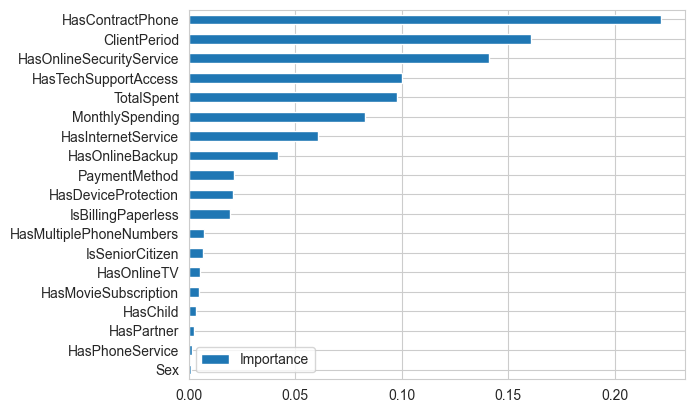

In [23]:
pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['Importance']).sort_values('Importance').plot(kind='barh')
plt.show()

In [24]:
clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', solver='saga', max_iter=1000))
])
params = {
    'logreg__C': np.arange(1, 100, 0.1)
}
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='roc_auc',
    cv=10,
    refit=True,
    n_jobs=-1
)

In [25]:
logreg = grid_search.fit(X, y)

In [26]:
logreg.best_score_

0.8433278522861174

In [27]:
logreg.best_params_

{'logreg__C': 15.600000000000012}

In [28]:
X = train[feature_cols]
X.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)


In [29]:
y = train[target_col]
y.head()

0    0
1    0
2    1
3    0
4    0
Name: Churn, dtype: int64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level='Silent',
    eval_metric='AUC:hints=skip_train~false',
    grow_policy='Lossguide',
    metric_period=1000,
    loss_function='CrossEntropy',
    early_stopping_rounds=10,
    min_data_in_leaf=100
)
params = {
    'n_estimators': [300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [4, 5, 6],
    'l2_leaf_reg': [3, 5, 10, 15]
}

In [ ]:
catboost.grid_search(params, X, y, cv=5, plot=True, refit=True)

In [36]:
catboost.best_score_

{'learn': {'CrossEntropy': 0.37404326590884585, 'AUC': 0.8776910358862102}}

In [37]:
catboost.get_params()

{'loss_function': 'CrossEntropy',
 'logging_level': 'Silent',
 'metric_period': 1000,
 'eval_metric': 'AUC:hints=skip_train~false',
 'early_stopping_rounds': 10,
 'cat_features': ['Sex',
  'IsSeniorCitizen',
  'HasPartner',
  'HasChild',
  'HasPhoneService',
  'HasMultiplePhoneNumbers',
  'HasInternetService',
  'HasOnlineSecurityService',
  'HasOnlineBackup',
  'HasDeviceProtection',
  'HasTechSupportAccess',
  'HasOnlineTV',
  'HasMovieSubscription',
  'HasContractPhone',
  'IsBillingPaperless',
  'PaymentMethod'],
 'grow_policy': 'Lossguide',
 'min_data_in_leaf': 100,
 'depth': 4,
 'l2_leaf_reg': 15,
 'iterations': 300,
 'learning_rate': 0.1}

In [38]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])
params = {
    'knn__n_neighbors': np.arange(1, 101),
    'knn__metric': ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean']
}
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='roc_auc',
    cv=10,
    refit=True,
    n_jobs=-1
)

In [39]:
knn = grid_search.fit(X, y)

In [40]:
knn.best_score_

0.8364529614693353

In [41]:
knn.best_params_

{'knn__metric': 'euclidean', 'knn__n_neighbors': 74}

In [42]:
clf = RandomForestClassifier(n_estimators=200)
params = {
    'min_samples_split': [9],
    'min_samples_leaf': [18]
}
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='roc_auc',
    cv=5,
    refit=True,
    n_jobs=-1
)

In [47]:
rf = grid_search.fit(X, y)

In [48]:
rf.best_score_

0.8434309575817904

In [50]:
meta = CatBoostClassifier(
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=0,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.08,
    max_depth=10,
    min_data_in_leaf=10,
    n_estimators=10,
    random_strength=11,
    subsample=0.1
)
stacking = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("knn", knn),
        ("rf", rf),
        ("catboost", catboost),
    ],
    final_estimator=meta,
    n_jobs=-1,
)

In [51]:
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('logreg',
                                GridSearchCV(cv=10,
                                             estimator=Pipeline(steps=[('scaler',
                                                                        StandardScaler()),
                                                                       ('logreg',
                                                                        LogisticRegression(max_iter=1000,
                                                                                           penalty='l1',
                                                                                           solver='saga'))]),
                                             n_jobs=-1,
                                             param_grid={'logreg__C': array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4...
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
                                             scoring='roc_auc')),
                               ('rf',
                                GridSearchCV(cv=5,
                                             estimator=RandomForestClassifier(n_estimators=200),
                                             n_jobs=-1,
                                             param_grid={'min_samples_leaf': [18],
                                                         'min_samples_split': [9]},
                                             scoring='roc_auc')),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x153581820>)],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x157e8be80>,
                   n_jobs=-1)

In [54]:
roc_auc_score(y_test, stacking.predict_proba(X_test)[:, 1])

0.8506918775706638

In [77]:
best_model = stacking

In [82]:
X_test = test_encoded
submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv')